In [17]:
# Finite element method for 2D Poisson's equation

import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

In [18]:
# Define the domain and the mesh
xmin, xmax, ymin, ymax = 0, 20e-9, 0, 20e-9
nx = 50 ; ny = nx
hx, hy = (xmax-xmin)/nx, (ymax-ymin)/ny
xx = np.linspace(xmin, xmax, 2*nx+1)
yy = np.linspace(ymin, ymax, 2*ny+1)
X, Y = np.meshgrid(xx, yy)

In [19]:
elements = []
nodes = []
charge_position = []
for i in range(2*nx+1):
    for j in range(2*ny+1):
        nodes.append([xx[i], yy[j]])
        if i < 2*nx and j < 2*ny and i % 2 == 0 and j % 2 == 0:
            n1 = i*(2*ny+1) + j
            n2 = i*(2*ny+1) + (j + 1)
            n3 = i*(2*ny+1) + (j+2)
            n4 = (i+1)*(2*ny+1) + j
            n5 = (i+1)*(2*ny+1) + (j + 1)
            n6 = (i+1)*(2*ny+1) + (j + 2)
            n7 = (i+2)*(2*ny+1) + j
            n8 = (i+2)*(2*ny+1) + (j + 1)
            n9 = (i+2)*(2*ny+1) + (j + 2)
            elements.append([n7, n9, n1, n8, n5, n4])
            elements.append([n3, n1, n9, n2, n5, n6])
            if i == nx and (j == (2 * ny+1)//3 - 1 or j == 2 * (2 * ny+1)//3 - 1):
                charge_position.append(len(elements))
            # if i == nx and j == ny:
            #     charge_position.append(len(elements))


def lou(phi):
    e0 = 8.85e-12
    e = 1.6e-19
    z = 1
    c0 = 100
    ce = 0
    k = 1.38e-23
    T = 300
    kT = k * T
    # rhs = - e * (c0 * np.exp(-z *e* phi / kT) - ce *np.exp(z *e* phi / kT))/e0
    rhs = -  e*(c0 * np.exp(-z *e* phi / kT))/e0
    # print(max(rhs))
    # print(rhs)
    return rhs
def dbasis(x,y):
    return np.array([
        [-3 + 4 * x + 4 * y, 4 * x - 1, 0,-8*x - 4*y + 4, 4*y, -4*y],
        [-3 + 4 * x + 4 * y, 0, 4 * y - 1, -4*x, 4*x, -8*y - 4*x + 4]
    ]) # return shape (2,6)

In [20]:
# Boundary conditions and right-hand side
bc = []
for j in range(2 * ny+1):
    n = j
    bc.append([n, 2])
    n = 2 * nx*(2*ny+1) + j
    bc.append([n, 0])
for i in range(2 * nx+1):
    n = i*(2 * ny+1)
    bc.append([n, 0])
    n = i*(2 * ny+1) + 2 * ny
    bc.append([n, 0])

In [21]:
nnodes = len(nodes)
nedges = len(elements)
A = np.zeros([nnodes,nnodes])
F = np.zeros(nnodes)
m = 6
# Step 3a: set up quadrature nodes in the triangle
xy = np.array([[0, 1],
                [0, -0.5],
                [0, 0],
                [0.5, 0],
                [1, 0],
                [0.5, 0.5]])
# ww = np.array([1,2,1,2,1,2],dtype="float64")
ww = np.array([1,1,1,1,1,1],dtype='float64')
ww /= np.sum(ww)

for e in range(nedges):
    n1, n2, n3, n4, n5, n6 = elements[e]
    x1, y1 = nodes[n1]
    x2, y2 = nodes[n2]
    x3, y3 = nodes[n3]
    x4, y4 = nodes[n4]
    x5, y5 = nodes[n5]
    x6, y6 = nodes[n6]
    position = np.array([[0,1,0],[0,0,1]])
    JF = np.array([[x2-x1, x3-x1], [y2-y1, y3-y1]])
    invJF = np.linalg.inv(JF)
    detJF = np.linalg.det(JF)
    ke = np.zeros((m, m))

    for w , x , y in zip(ww,xy[:,0],xy[:,1]):

        basis = np.array([
            (1 - x - y) * (1 - 2 * x - 2 * y),
            x * (2 * x - 1),
            y * (2 * y - 1),
            4 * x * (1 - x - y),
            4 * x * y,
            4 * y * (1 - x - y)
        ])

        
        # derivatives of quadratic basis functions
        dbasis = np.array([
            [-3 + 4 * x + 4 * y, 4 * x - 1, 0,-8*x - 4*y + 4, 4*y, -4*y],
            [-3 + 4 * x + 4 * y, 0, 4 * y - 1, -4*x, 4*x, -8*y - 4*x + 4]
        ])


        dphi = invJF.dot(dbasis)

        ke = (detJF) * w * dphi.T @ dphi
        for i in range(m):
            for j in range(m):
                A[elements[e][i], elements[e][j]] += ke[i,j]
                
def iteration(u):
    F = np.zeros(nnodes)
    for e in range(nedges):
        n1, n2, n3, n4, n5, n6 = elements[e]
        x1, y1 = nodes[n1]
        x2, y2 = nodes[n2]
        x3, y3 = nodes[n3]
        x4, y4 = nodes[n4]
        x5, y5 = nodes[n5]
        x6, y6 = nodes[n6]
        position = np.array([[0,1,0],[0,0,1]])
        JF = np.array([[x2-x1, x3-x1], [y2-y1, y3-y1]])
        invJF = np.linalg.inv(JF)
        detJF = np.linalg.det(JF)
        ke = np.zeros((m, m))
        for w , x , y in zip(ww,xy[:,0],xy[:,1]):

            basis = np.array([
                (1 - x - y) * (1 - 2 * x - 2 * y),
                x * (2 * x - 1),
                y * (2 * y - 1),
                4 * x * (1 - x - y),
                4 * x * y,
                4 * y * (1 - x - y)
            ])
            # position = np.array([[0,1,0],[0,0,1]])
            # Fx = np.dot(JF,position)+np.array([[x1,x1,x1],[y1,y1,y1]]) # (2,3)
            fx = lou(u[elements[e]]) # (3,)
            fe = fx*detJF*basis*w # (3,)
            for i in range(6):
                F[elements[e][i]] += fe[i]
            if e in charge_position:
                F[elements[e]] += 1
        # print(max(F))
    for n, val in bc:
            F[n] = val
    for n, val in bc:
        A[n, :] = 0
        A[n, n] = 1
    u = np.linalg.solve(A, F)
    return u

In [22]:
# u = np.random.rand(nnodes)
u = np.random.rand(nnodes)
eps = 1e-10
for _ in tqdm(range(100)):
    u_old = u
    u = iteration(u_old)
    if np.linalg.norm(u-u_old)<eps:
        break
    # print(np.linalg.norm(u))

  1%|          | 1/100 [00:14<24:39, 14.95s/it]


In [23]:
np.linalg.norm(u-u_old)

0.0

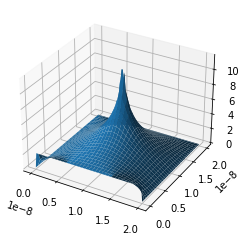

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, u.reshape((2*nx+1, 2*ny+1)))
plt.show()

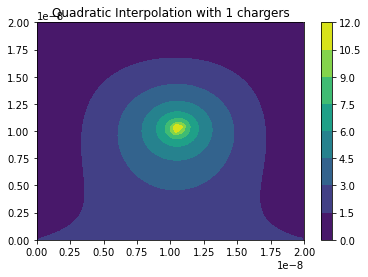

In [25]:
plt.contourf(X,Y,u.reshape((2*nx+1, 2*ny+1)))
# plt.title(f"Quadratic Interpolation with nx = {nx}")
plt.title(f"Quadratic Interpolation with {len(charge_position)} chargers")
plt.colorbar()

/var/folders/g0/6617w89s72vchxjk63ggp5x00000gn/T/ipykernel_5795/3107796839.py:8: RuntimeWarning: divide by zero encountered in log
  color = 2 * np.log(np.hypot(Ex, Ey))


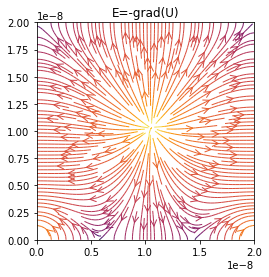

In [27]:
from matplotlib.patches import Circle
U_array = u.reshape((2*nx+1, 2*ny+1))
Ey, Ex = np.gradient(-U_array)
fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the streamlines with an appropriate colormap and arrow style
color = 2 * np.log(np.hypot(Ex, Ey))
ax.streamplot(X, Y, Ex, Ey, color=color, linewidth=1, cmap=plt.cm.inferno,
              density=2, arrowstyle='->', arrowsize=1.5)

# Add filled circles for the charges themselves
charge_colors = {True: '#aa0000', False: '#0000aa'}
# for q, pos in charges:
#     ax.add_artist(Circle(pos, 0.05, color=charge_colors[q > 0]))

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_aspect('equal')
ax.set_title('E=-grad(U)')
plt.show()